In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt
import os

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///hawaii.sqlite")


In [5]:
# reflect an existing database into a new model
# Declare a Base using `automap_base()`
Base = automap_base()

# Use the Base class to reflect the database tables
Base.prepare(engine, reflect=True)

# reflect the tables
Base.classes.keys()


['measurement', 'station']

In [6]:
# View all of the classes that automap found
print(Base.classes.keys())

['measurement', 'station']


In [7]:
# Save references to each table
measurement = Base.classes.measurement
station = Base.classes.station

In [8]:
# Create our session (link) from Python to the DB
session = Session(engine)

## Inspecting the database

In [9]:
# Create the inspector and connect it to the engine
inspector = inspect(engine)
# Retrieve the column names for the two tables: measurement and station
m_columns = inspector.get_columns('measurement')
s_columns = inspector.get_columns('station')
# Printint the column names
print('Column names for the table Measurement:')
for column in m_columns:
    print(column["name"], column["type"])
print('Column names for the table Station:')
for column in s_columns:
    print(column["name"], column["type"])

Column names for the table Measurement:
id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT
Column names for the table Station:
id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


# Exploratory Precipitation Analysis

In [10]:
# Find the most recent date in the data set.
recentdate = session.query(measurement.date).order_by(measurement.date.desc()).first()
print(recentdate)

('2017-08-23',)


2017-08-23
2016-08-23


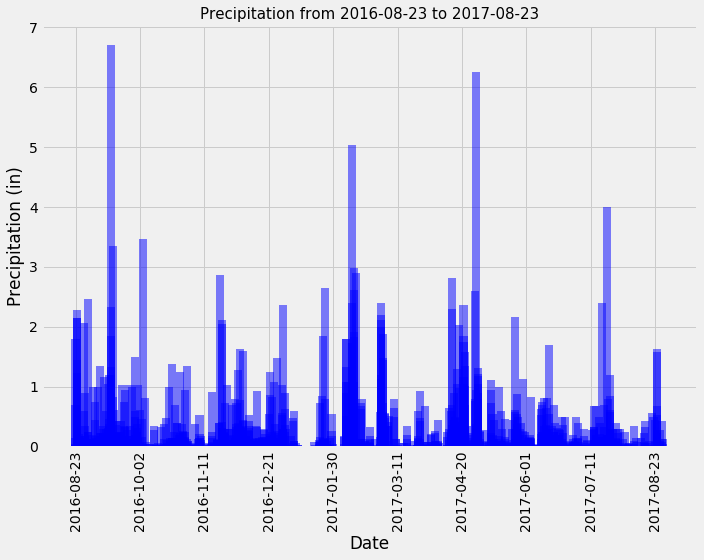

In [11]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 
recent_date = dt.datetime.strptime(recentdate[0], '%Y-%m-%d').date()
print(recent_date)
# Calculate the date one year from the last date in data set.
query_date = recent_date - dt.timedelta(days=365)
print(query_date)

# Perform a query to retrieve the data and precipitation scores
sel = [measurement.date,
       measurement.prcp]

data = session.query(*sel).\
                  filter(measurement.date >= query_date).all()

# Save the query results as a Pandas DataFrame and set the index to the date column
df = pd.DataFrame(data).set_index('date')

# Sort the dataframe by date
df.sort_index()
df.head(5)
# Use Pandas Plotting with Matplotlib to plot the data
fig, ax = plt.subplots(figsize=(10,8))
plt.bar(df.index.tolist(),df['prcp'],width = 5 ,color='b', alpha=0.5, align="center",label='Precipitation')
# x-ticks settings
ax.xaxis.set_major_locator(plt.MaxNLocator(12))
plt.xticks(rotation='vertical')
# title
plt.title(f'Precipitation from {query_date} to {recent_date}', fontsize=(15))
# label of the axis
plt.xlabel(f'Date')
plt.ylabel('Precipitation (in)')
plt.tight_layout()
figname = os.path.join('.','output','bar_precipitation.png')
plt.savefig(figname)



In [12]:
# Use Pandas to calcualte the summary statistics for the precipitation data
df.describe()

,prcp
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [13]:
# Design a query to calculate the total number stations in the dataset
total_stations = session.query(station.station).distinct().count()
print(total_stations)

9


In [14]:
# Design a query to find the most active stations (i.e. what stations have the most rows?)
# List the stations and the counts in descending order.
sel = [measurement.station,
    func.count(measurement.station)]
active_station = session.query(*sel).\
                         group_by(measurement.station).\
                         order_by(func.count(measurement.station).desc()).\
                         all()
active_station



[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [15]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
most_active_station = active_station[0][0]
sel = [func.min(measurement.tobs),
       func.max(measurement.tobs),
       func.avg(measurement.tobs)]

most_active = session.query(*sel).\
                filter(measurement.station == most_active_station).all()

print(f'Station {active_station[0][0]}:\nLowest temperture recorded: {most_active[0][0]}\nHighest temperature recorded: {most_active[0][1]}\nAverage temperature: {most_active[0][2]:.1f}')

Station USC00519281:
Lowest temperture recorded: 54.0
Highest temperature recorded: 85.0
Average temperature: 71.7


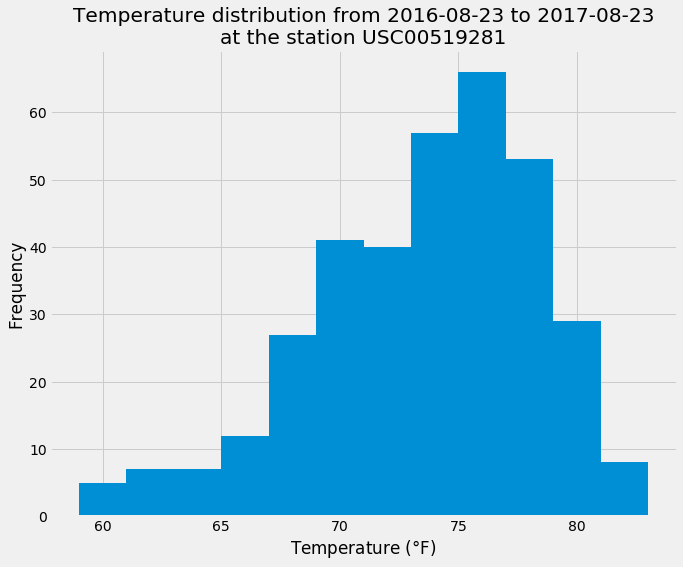

In [16]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
sel = [measurement.tobs]

active_data = session.query(*sel).\
                  filter(measurement.station == most_active_station).\
                  filter(measurement.date >= query_date).all()

active_df = pd.DataFrame(active_data)
active_df.head(5)
fig, ax = plt.subplots(figsize=(10,8))
plt.hist(active_df['tobs'],bins=12)
plt.title(f'Temperature distribution from {query_date} to {recent_date}\nat the station {most_active_station}')
plt.ylabel('Frequency')
plt.xlabel('Temperature ($\degree$F)')
figname = os.path.join('.','output','histogram_T.png')
plt.savefig(figname)

# Close session

In [17]:
# Close Session
session.close()